Similarly, for the multivariate Gaussian case, we can write the log-likelihood function as:

$l(n_i, y_i | \mu_i, s_i, \Sigma) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - (\mu_i + s_i)$



In [1]:
import autograd.numpy as np
from autograd.numpy import linalg
import matplotlib.pyplot as plt
from autograd.numpy.random import poisson, normal, multivariate_normal
import emcee as mc
import george as ge

def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    #t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = 0.
    for i in range(N):
        t3 += ni[i] * np.log(mu[i] + s[i])
        t3 -= (mu[i] + s[i])
    result =  t2 + t3 #+ t1 #t1 breaks it for some reason
    if not(np.isfinite(result)):
        return np.infty
    else:
        return -result


from autograd import grad

nln_MV_grad = grad(neg_log_like_PGP)


def f1(x):
    return (1./(np.exp(x-2)))

def f2(x):
    return 1./x

def f3(x):
    return 1.*np.exp(-3.*(x-0.7))

def f4(x):
    return (1./np.log(x+1))

def f5(x):
    return 1./(np.power(x+.3,2))



Construct kernel of the form:

$\Sigma (x,x') = Ae^{\left(\frac{d-(x+x')}{2a} \frac{-(x-x')^2}{e^{(bx+c)^2} +e^{(bx'+c)^2}}\right)}$

In [2]:
def makekernel(x, k, params, sigma = None):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    if sigma!=None:
        for i in range(N):
            cov[i][i] += sigma[i]
    return cov

#kernel with constant lengthscale but variable height
def kernel1(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

#kernel with constant lengthscale but variable height
def kernel2(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

-612.1983912011394
[-0.06747401  0.13109579 -0.30985194  0.66036721 -0.31508119  0.07890972
  0.61781045 -0.10653157  0.70367909 -0.5712167  -0.81880028 -0.03766442
  0.09997086  0.44019513 -0.15673499 -0.39031239  0.79587797 -0.67472487
 -0.71440242 -0.53317914 -0.56476344 -0.36712911 -0.62395361 -0.41580444
  0.28063142]


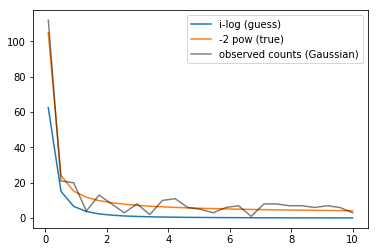

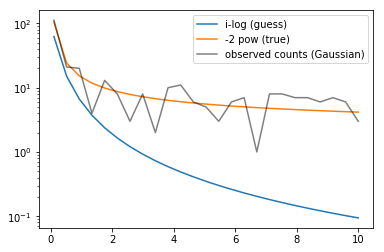

In [13]:
%matplotlib inline

N = 25
x = np.linspace(.1,10,N)
xtrue = np.linspace(.1,10,N)
scale = 1e1
kparams1 = [10., 5., 1., 0., 10.]
kparams2 = [5., .5]

ymodel = scale * f5(x)
ytrue = scale * f4(x)
ytrue_t = scale * f4(xtrue)
yguess = scale * f4(xtrue)
signal0 = np.zeros(N)


cov = makekernel(xtrue, kernel1, kparams1)
#cov = makekernel(xtrue, kernel2, kparams2)


n_G = poisson(ytrue_t)


print neg_log_like_PGP(yguess, signal0, n_G, yguess, cov)
print nln_MV_grad(yguess, signal0, n_G, yguess, cov)

yg_up = yguess + 2.*np.sqrt(yguess)
yg_low = yguess - 2.*np.sqrt(yguess)

for i in range(N):
    if yg_low[i]<0.:
        yg_low[i] = 1e-5
boundarray = [(yg_low[i], yg_up[i]) for i in range(N)]




plt.figure()
plt.plot(x,ymodel, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(xtrue,n_G, 'k-', alpha = 0.5, label = "observed counts (Gaussian)")
plt.legend(loc='upper right')

plt.figure()
plt.yscale('log')
plt.plot(x,ymodel, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(xtrue,n_G, 'k-', alpha = 0.5, label = "observed counts (Gaussian)")
plt.legend(loc='upper right')

plt.show()

[70.46887054  2.86947689  0.52835502  5.90970821]


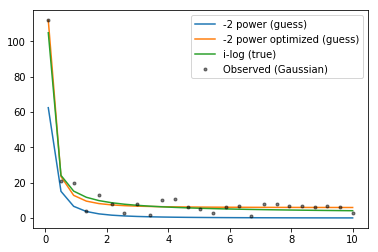

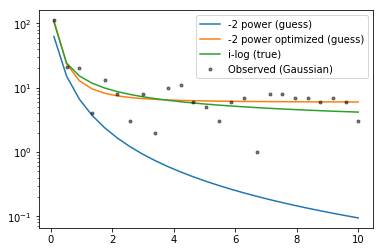

In [14]:
from scipy.optimize import curve_fit

def f4_opt(params, x):
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    return ((1.*a)/(np.log(b*x + c)))+d

def f5_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def f5_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return f5_opt(x, params)


p0 = (scale, 1., .3, 0)
popt, pcov = curve_fit(f5_preopt, xtrue, n_G, p0=p0)
print popt

ymodel_opt = f5_opt(xtrue, popt)


plt.figure()
plt.plot(x,ymodel, label = "-2 power (guess)")
plt.plot(xtrue,ymodel_opt, label = "-2 power optimized (guess)")
plt.plot(x,ytrue, label = "i-log (true)")
plt.plot(xtrue,n_G,'k.', alpha = 0.5, label = "Observed (Gaussian)")
plt.legend(loc='upper right')

plt.figure()
plt.semilogy(x,ymodel, label = "-2 power (guess)")
plt.semilogy(xtrue,ymodel_opt, label = "-2 power optimized (guess)")
plt.semilogy(x,ytrue, label = "i-log (true)")
plt.semilogy(xtrue,n_G,'k.', alpha = 0.5, label = "Observed (Gaussian)")
plt.legend(loc='upper right')

plt.show()

yguess = f5_opt(xtrue, popt)
ymodel = f5_opt(x, popt)

In [15]:
from scipy.optimize import minimize
solnG = minimize(neg_log_like_PGP, ymodel,  method="L-BFGS-B", args = (signal0, n_G, yguess, cov), options={'ftol' : 1e2 * np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5})#, bounds = boundarray)

mu_opt_G = solnG.x

print solnG

delta_mu_opt_G = np.diag(solnG.hess_inv.matmat(np.eye(N)))

      fun: -614.6125437848357
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.04858394e-04,  1.08093445e-01, -5.54393864e-01,  5.83588644e-01,
       -5.85691851e-01, -6.54495125e-02,  7.79948550e-01,  4.96007715e+00,
        9.60227908e+01,  1.27951382e+03,  1.21662423e+04,  7.99573032e+04,
        3.53391949e+05,  1.01060693e+06,  1.74698289e+06,  1.52664904e+06,
        5.06049917e+04, -1.19317575e+06, -8.40596905e+05,  1.04645732e+06,
        2.66926987e+06,  2.08013037e+06,  6.43909080e+05,  6.80853621e+04,
        1.44027987e+03])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 546
      nit: 0
   status: 2
  success: False
        x: array([111.92280915,  23.54522807,  12.86679505,   9.60606662,
         8.19752268,   7.46389366,   7.03391891,   6.76050723,
         6.57593868,   6.44550992,   6.34994483,   6.27784074,
         6.2221024 ,   6.17812723,   6.14282384,   6.11405347,
         6.09029825,   6.07045684,   6.05371441,   6.03945766

In [16]:
if(False):
    nwalker = 2*N
    prob = 0
    p0_walk = np.array([normal(loc=yguess, scale = np.sqrt(yguess)) for i in range(nwalker)])
    burnin = 1500
    nsteps = 3000


    sampler = mc.EnsembleSampler(nwalker, N, lprob, args = (signal0, n_G, yguess, cov))#, kwargs={"bounds":boundarray})
    print "Burnin..."
    p0_walk, prob, _ = sampler.run_mcmc(p0_walk, burnin)

    print "Sampling..."
    #sampler.reset()
    sampler.run_mcmc(p0_walk, nsteps)

    print "Done"
    chain = sampler.chain
    sampler.reset()



    true_chain = chain[:,burnin:,:]
    flat_chain = true_chain.reshape((-1,N))
    mean_mu_g = np.average(flat_chain, axis=0)
    print mean_mu_g

    nbins = N
    max_mu = np.empty(N)
    for i in range(N):
        hist, bin_edges = np.histogram(flat_chain[:,i], bins = nbins)
        maxindex = np.argmax(hist)

        max_mu[i] = np.average([bin_edges[maxindex], bin_edges[maxindex+1]])

    import corner
    #print "Plotting Corner..."
    #fig = corner.corner(flat_chain, bins=nbins,  truths = solnG.x)

    #plt.show()



25


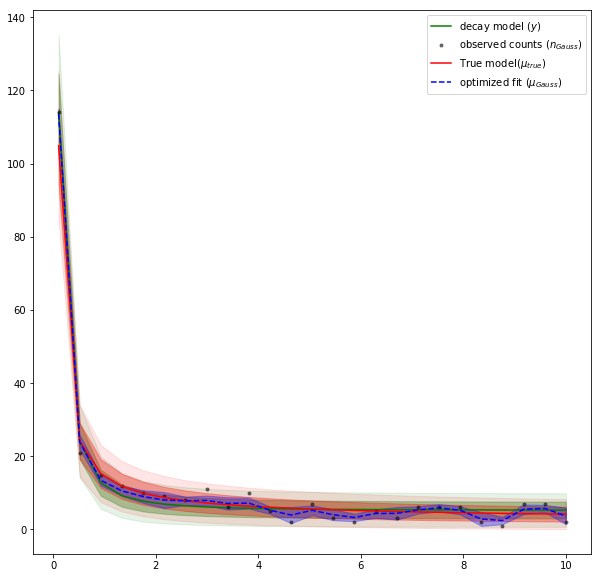

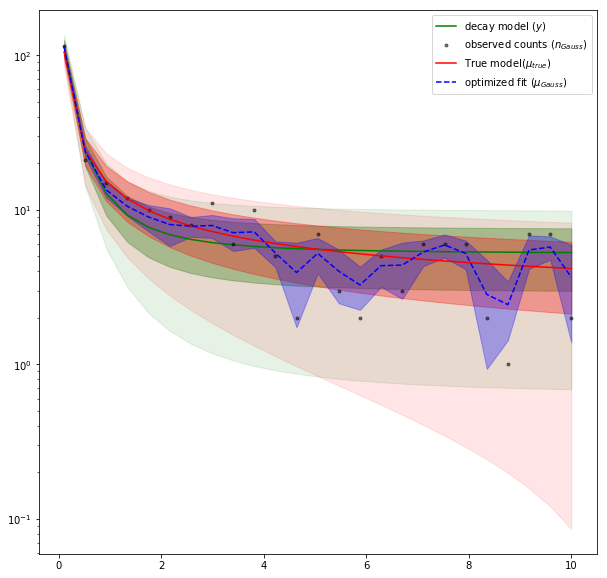

In [12]:
%matplotlib inline
plt.figure()

fill_std=True
ym_up = ymodel + 2.*np.sqrt(ymodel)
ym_low = ymodel - 2.*np.sqrt(ymodel)
print len(ymodel)
gp_std = np.sqrt(ymodel)
yguess_std_low = np.empty(len(ymodel))
yguess_std_low2 = np.empty(len(ymodel))
ytrue_std_low = np.empty(len(ymodel))
mu_opt_low = np.empty(N)
for i in range(N):
    if ymodel[i]-gp_std[i]<0.1: 
        yguess_std_low[i] = 0.1
    else:
        yguess_std_low[i] = ymodel[i]-gp_std[i]
    if ymodel[i]-2*gp_std[i]<0.1: 
        yguess_std_low2[i] = 0.1
    else:
        yguess_std_low2[i] = ymodel[i]-2*gp_std[i]
    if ytrue[i]-np.sqrt(ytrue[i])<0.1: 
        ytrue_std_low[i] = 0.1
    else:
        ytrue_std_low[i] = ytrue[i]-np.sqrt(ytrue[i])
    if mu_opt_G[i]-np.sqrt(delta_mu_opt_G[i])<1e-2: 
        mu_opt_low[i] = 1e-2
    else:
        mu_opt_low[i] = mu_opt_G[i]-np.sqrt(delta_mu_opt_G[i])
        
plt.figure(figsize=(10,10))
plt.plot(x, ymodel, 'g-', label = "decay model ($y$)")
plt.plot(xtrue, n_G,'k.', label = "observed counts ($n_{Gauss}$)", alpha = .5)
#plt.plot(xtrue, max_mu, 'm.', label = "emcee mean", alpha = .75)
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.plot(xtrue, mu_opt_G,'b--', label = "optimized fit ($\mu_{Gauss}$)")
if(fill_std == True):
    plt.fill_between(x, ymodel+gp_std, ymodel-gp_std, color = 'g', alpha=0.3, edgecolor="none")
    plt.fill_between(x, ymodel+2*gp_std, ymodel-2*gp_std, color = 'g', alpha=0.1, edgecolor="none")
    plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
    plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
    plt.fill_between(x, mu_opt_G + np.sqrt(delta_mu_opt_G), mu_opt_G - np.sqrt(delta_mu_opt_G), color = 'b', alpha=0.3, edgecolor="none")
    
plt.legend(loc="upper right")

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(x, ymodel, 'g-', label = "decay model ($y$)")

plt.plot(xtrue, n_G,'k.', label = "observed counts ($n_{Gauss}$)", alpha = .5)
#plt.plot(xtrue, max_mu, 'm.', label = "emcee mean", alpha = .75)
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.plot(xtrue, mu_opt_G,'b--', label = "optimized fit ($\mu_{Gauss}$)")

if(fill_std == True):
    plt.fill_between(x, ymodel+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")
    plt.fill_between(x, ymodel+2*gp_std, yguess_std_low2, color = 'g', alpha=0.1, edgecolor="none")
    plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue_std_low, color = 'r', alpha=0.3, edgecolor="none")
    plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
    plt.fill_between(x, mu_opt_G + np.sqrt(delta_mu_opt_G), mu_opt_low, color = 'b', alpha=0.3, edgecolor="none")

plt.legend(loc="upper right")


plt.show()